## TIME SERIES ANALYSIS

In [37]:
import copy
import datetime
import holidays
import ipdb
import matplotlib.pyplot as plt
import matplotlib.dates as md
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import warnings
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import LSTM
from math import log, exp
from scipy.stats import boxcox
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.nonparametric.smoothers_lowess import lowess

%matplotlib inline

In [38]:
# Settings
warnings.filterwarnings('ignore')
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize': (20, 5)})

In [39]:
with open("./datasets/mr_dataset.p", "rb") as file:
    df = pickle.load(file)

In [40]:
def convert_to_dtformat(df):
    """
    convert dataset to date-time-format
    """
    if 'tsda_tsmd_id' not in df.columns:
        return df

    df.Date = pd.to_datetime(df.tsda_timestamp, format='%m-%d-%m-%Y')
    df_t = df.set_index('tsda_timestamp')
    df_t = df_t.drop(["tsda_tsmd_id"], axis=1)
    return df_t

In [41]:
df = convert_to_dtformat(df)
df.head(2)

,tsda_field_value
tsda_timestamp,
2018-10-10 12:29:50+00:00,81.544
2018-10-10 12:29:52+00:00,81.520
2018-10-10 12:29:54+00:00,81.700


## Preprocessor library

### Resample

In [42]:
def resample_dataset(df, sampling='H'):
    """
    sampling:
    H = hourly frequency
    D = calendar day frequency
    W = weekly frequency
    M = month end frequency
    """
    df_r = df.resample(sampling).mean()
    return df_r

### Set bounds

In [43]:
def set_bounds(df, lower_bound='Monday', upper_bound='Sunday'):
    """
    Select start and end point of the dataset by specifying date or weekday.
    If weekday is spedified the first or last day in the dataset will be taken respectively.
    """
    weekdays = ['Monday', 'Tuesday', 'Wednesday',
                'Thursday', 'Friday', 'Saturday', 'Sunday']

    if lower_bound and upper_bound in weekdays:
        # The day of the week with Monday=0, Sunday=6.
        days = df.index.dayofweek
        idx_lower = next(day for day, val in enumerate(days) if val == 0)
        idx_upper = next(day for day, val in reversed(
            list(enumerate(days))) if val == 6)
        lower_bound = df.index[idx_lower]
        upper_bound = df.index[idx_upper]

    # remove obsolete data
    idx_lower = df[df.index < lower_bound].index
    idx_upper = df[df.index > upper_bound].index
    dfx = df.drop(idx_lower.union(idx_upper))
    return dfx

### Moving average

In [44]:
def moving_average(df, window_size=3):
    df_ma = copy.deepcopy(df)
    return df_ma.value.rolling(window_size, center=True, closed='both').mean()

### Loess smoothing

In [45]:
def loess_smoothing(df, frac=0.05):
    df_loess = copy.deepcopy(df)
    return pd.DataFrame(lowess(df_loess.value, np.arange(len(df_loess.value)), frac)[:, 1], index=df_loess.index, columns=['value'])

### Difference
A difference transform is a simple way for removing a systematic structure from the time series.

For example, a trend can be removed by subtracting the previous value from each value in the series. This is called first order differencing. The process can be repeated (e.g. difference the differenced series) to remove second order trends, and so on.

A seasonal structure can be removed in a similar way by subtracting the observation from the prior season, e.g. 12 time steps ago for monthly data with a yearly seasonal structure.

In [46]:
def difference(data, interval):
    """
    interval represent the number of lags to be differentiated
    1 for trend removal 
    12 for monthly data with a yearly seasonal structure
    """
    return [data[i] - data[i - interval] for i in range(interval, len(data))]

### Invert difference

In [47]:
def invert_difference(orig_data, diff_data, interval):
    return [diff_data[i-interval] + orig_data[i-interval] for i in range(interval, len(orig_data))]

### Normalize
Normalization is a rescaling of data from the original range to a new range between 0 and 1.

In [48]:
def normalize(data):
    scaler = MinMaxScaler()
    # Compute the minimum and maximum to be used for later scaling.
    scaler.fit(data)
    return scaler.transform(data)

### Invert normalize

In [49]:
def invert_normalize(transformed):
    scaler = MinMaxScaler()
    return scaler.inverse_transform(transformed)

### Power transformation
A power transform removes a shift from a data distribution to make the distribution more-normal (Gaussian). On a time series dataset, this can have the effect of removing a change in variance over time.

In [50]:
def power_transform(data):
    transformed, lmbda = boxcox(data)
    return transformed, lmbda

### Invert power transformation

In [51]:
def invert_power_transform(value, lam):
    inverted = [compute_inverted_value(x, lmbda) for x in transformed]

    def compute_inverted_value(value, lam):
        # log case
        if lam == 0:
            return exp(value)
        # all other cases
        return exp(log(lam * value + 1) / lam)

### Get dataset range

In [52]:
def get_range(df, t1, t2):
    """
    get dataset range between timepoint t1 and t2
    """    
    df_range = df[df.index >= t1]
    data_range = df_range[df_range.index <= t2]
    return data_range

### Plot dataset range

In [53]:
def plot_range(data):
    # major ticks on the mondays
    mondays = md.WeekdayLocator([md.MONDAY, md.SATURDAY])
    # minor ticks on the days
    alldays = md.DayLocator()

    fig, ax = plt.subplots()
    plt.plot(data.index, data.values)
    plt.xticks(rotation=45)
    ax.xaxis.set_major_locator(mondays)
    ax.xaxis.set_major_formatter(md.DateFormatter('%Y-%m-%d'))
    plt.grid(linestyle=":", color='black')
    plt.show()    

### Accuracy metrics

In [54]:
def forecast_accuracy(forecast, actual):
    # Mean absolute percentage error
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))
    # Mean Absolute Error 
    mae = np.mean(np.abs(forecast - actual))
    # Root mean squared error
    rmse = np.mean((forecast - actual)**2)**.5

    return({'mape': mape, 
            'mae': mae, 
            'rmse':rmse})

### Remove constant values
we have had a bug on our gateways which led to constant values on the modbus for some time

In [55]:
def remove_const_vals(dfin):
    ts = dfin.copy()
    for i in range(ts.shape[0]-2):
        if ts.iloc[i+2]["tsda_field_value"] == ts.iloc[i]["tsda_field_value"]:
            ts["tsda_field_value"][i] = np.nan
    return ts

### Augmented Dickey Fuller test
The ADF test uses an autoregressive model and optimizes an information criterion across multiple different lag values. 

p-value <= 0.05 rejects the null hypothesis, the data are stationary.

In [56]:
def adf_test(data, stats=False):
    result = adfuller(data, autolag='AIC')    
    if stats:
        print('ADF Test Statistic: {}'.format(result[0]))
        print('p-value: {}'.format(result[1]))
        for key, value in result[4].items():
            print('Critial Values:')
            print('   {}, {}'.format(key, value))
        if result[1] > 0.05:
            print('\n=> Time series is NOT stationary')
        else:
            print('\n=> Time series is stationary!')
    return result

### Split into test and train

In [57]:
def split_dataset(data, x1=70, x2=30):
    assert (x1+x2 == 100), "x1 = {} + x2 {} is not 100".format(x1,x2) 
    if not 'week_num' in data.columns:
        data = add_week_num(df)    
    train_idx = round(max(data['week_num'])*x1*0.01)
    train = data[data['week_num'] < train_idx]
    test = data[data['week_num'] >= train_idx]    
    return train, test

### Add additional features

#### Add weekday

In [58]:
def add_weekday(df):
    wd = np.zeros(len(df))
    wd = df.index.map(lambda x: x.strftime("%A"))
    df_w = df.assign(weekday=wd.values)
    return df_w

#### Add week number

In [59]:
def add_week_num(df):
    """
    Starts with the first sample. It is recommended to combine this function with set_bounds()
    """
    days = df.index.dayofweek
    wn = np.zeros(len(df))
    days_diff = np.diff(days)
    week_end_idx = np.where(days_diff == 1)[0]
    counter = 0
    for idx, idx_end in enumerate(week_end_idx):
        if idx == 0:
            wn[0:idx_end] = counter
        else:
            wn[week_end_idx[idx-1]+1:idx_end+1] = counter    
        counter = counter + 1
    wn[week_end_idx[-1]+1:] = counter   
    df_wn = df.assign(week_num=wn.astype(int))
    return df_wn

#### Add calender week

In [60]:
def add_calender_week(df):
    # Week number of the year (Monday as the first day of the week)
    wd = df.index.map(lambda x: x.strftime("%W"))
    df_cw = df.assign(calender_week=wd.values)
    return df_cw

#### Add weekend

In [61]:
def add_weekend(df):
    wd = df.index.map(lambda x: True if (x.strftime("%w") == '0' or x.strftime("%w") == '6') else False) 
    df_w = df.assign(weekend=wd.values)
    return df_w

#### Add holiday 

In [62]:
def add_holiday(df):
    hd = np.zeros(len(df))
    hd = df.index.map(lambda date: date in holidays.Germany())
    df_h = df.assign(holiday=hd.values)
    return df_h

## Data Preparation

In [63]:
hours = 2
sampling = str(hours)+'h'
trend = 1
seasonality = int(7*24/hours)

### Resample

In [64]:
dfx = resample_dataset(df, sampling)

### Set bounds

In [65]:
dfx = set_bounds(dfx, lower_bound='Monday', upper_bound='Sunday')

### Remove constant values

In [66]:
dfx = remove_const_vals(dfx)

### Plot dataset

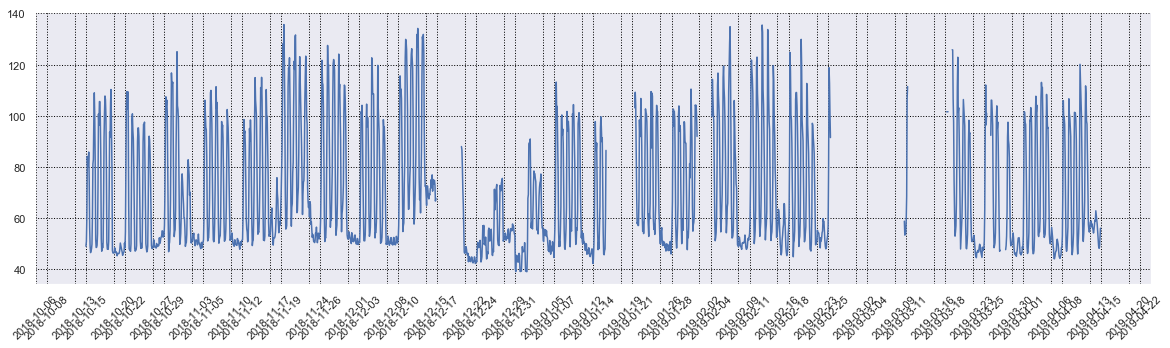

In [67]:
plot_range(dfx)

### Add features

In [68]:
# dfx = add_week_num(dfx)
dfx = add_weekend(dfx)
dfx = add_holiday(dfx)
dfx.tail()

,tsda_field_value,weekend,holiday
tsda_timestamp,,,
2019-04-14 14:00:00+00:00,49.031788,True,False
2019-04-14 16:00:00+00:00,48.178217,True,False
2019-04-14 18:00:00+00:00,48.716806,True,False
2019-04-14 20:00:00+00:00,52.789962,True,False
2019-04-14 22:00:00+00:00,56.044767,True,False


## Missing data

### Inspect missing data

Lets have a look if there are any NaNs

In [76]:
dfx.isnull().values.any()

True

Ok, we have NaNs
Lets check if they are between the gaps

In [77]:
t1 = '2019-01-19 00:00:01+00:00'
t2 = '2019-01-21 00:00:01+00:00'

x = get_range(dfx, t1, t2)
x.head(2)

,tsda_field_value,weekend,holiday
tsda_timestamp,,,
2019-01-19 02:00:00+00:00,NaN,True,False
2019-01-19 04:00:00+00:00,NaN,True,False


=> Missing data are represented by NaNs

### Prepare dataset

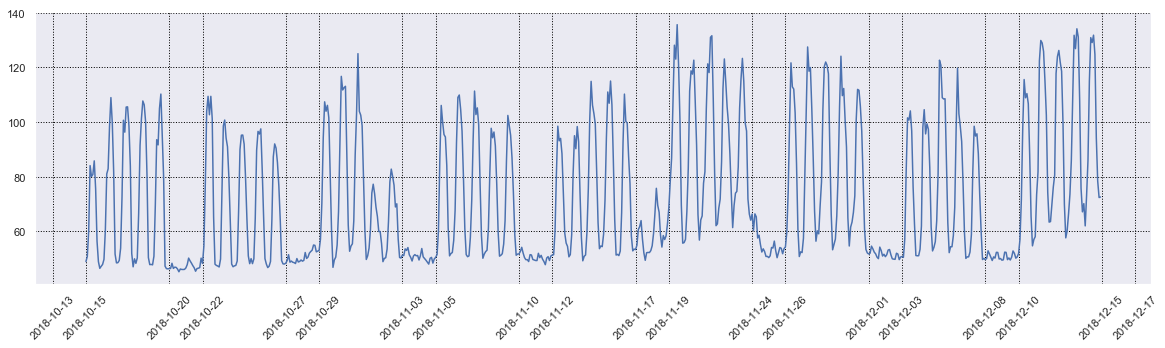

In [78]:
t1 = '2018-10-13 00:00:00+00:00'
t2 = '2018-12-14 23:00:00+00:00'

data = get_range(dfx, t1, t2)
plot_range(data['tsda_field_value'])

Depending on the resampling there might be missing data points. In that case use a standard time interpolation method to fill them. This method got the best results according to:
https://medium.com/@drnesr/filling-gaps-of-a-time-series-using-python-d4bfddd8c460

In [79]:
# fill in any missing values
if data.isnull().sum(axis = 0).any() > 0:
    print('The following NaNs will be imputed: \n{}'.format(pd.isnull(dfx).any(1).nonzero()[0]))
    data = data.interpolate(method='time')

In [80]:
# remove the last week 
t1 = '2018-12-08 00:00:00+00:00'
t2 = '2018-12-14 23:00:00+00:00'

test = copy.deepcopy(data)
test[(data.index >= t1) & (test.index <= t2)] = np.nan
data = data.assign(tsda_field_value_mv=test['tsda_field_value'])
data.tail(3)

,tsda_field_value,weekend,holiday,tsda_field_value_mv
tsda_timestamp,,,,
2018-12-14 18:00:00+00:00,78.416599,False,False,NaN
2018-12-14 20:00:00+00:00,72.407919,False,False,NaN
2018-12-14 22:00:00+00:00,72.606205,False,False,NaN


### Naive methods

In [38]:
# This will allow us to work with the data as one array of floating point values rather than mixed types
dataset.replace('?', nan, inplace=True)
dataset = dataset.astype('float32')

NameError: name 'dataset' is not defined

#### Method XX

In [ ]:
# remove trend from time series
diff_trend = difference(data['tsda_field_value'], trend)
# remove seasonality from time series
diff_seas = difference(diff_trend, seasonality)
# test for stationarity 
res = adf_test(diff_seas)
assert (res[1] < 0.05), "Time series is not stationary!"

# interpolate dataframe index

# create a DataFrame to access pandas imputation functions
test = pd.DataFrame(diff_seas, columns = ['value'], index=range(len(diff_seas)))
# insert missing values
test["value"][(test.index >= 520) & (test.index <= 580)] = np.NaN
test = test.fillna(test.rolling(1,min_periods=1,).mean())
# test = test.interpolate(method='polynomial', order=5)

# value - by - value forecast

# Insert missing values
# test = copy.deepcopy(diff_seas)
# for i in range(80):
#     test[500+i] = np.NaN
# fill in values
# test = test.interpolate(method='time')


preprocessor get powertransform
preprocessor get smoothing

data exploration -> smooth dataset 

make the data stationary

perform a stationarity test

remove one week

perform tests

reverse differentiation

make table 

sarima


### SARIMA

#### Pyramid

In [ ]:
# Seasonal - fit stepwise auto-ARIMA
smodel = auto_arima(data, start_p=1, start_q=1,
                    test='adf',
                    max_p=3, max_q=3, m=7,
                    start_P=0, seasonal=True,
                    d=None, D=1, trace=True,
                    error_action='ignore',
                    suppress_warnings=True,
                    stepwise=True)
smodel.summary()

#### Hyperopt

### VAR
vector autoregressive model forecasting requires a stationary series.

#### Validate differentiation
Can we convert a differentiated series back to its original form?

In [ ]:
diff_data = difference(data['tsda_field_value'], seasonality)
inv_data = invert_difference(data['tsda_field_value'], diff_data, seasonality)
diff = len(data['tsda_field_value']) - len(diff_data)

df_inv = np.empty(len(data))
df_inv[:] = np.nan
df_inv[diff:] = inv_data
data = data.assign(tsda_field_value_inv=df_inv)

metrics = forecast_accuracy(inv_data, data['tsda_field_value'][diff:].values)
print('mape = {}, mae = {}, rmse = {}'.format(metrics['mape'], metrics['mae'], metrics['rmse']))

plt.plot(data['tsda_field_value_inv'], linewidth=3.0)
plt.plot(data['tsda_field_value'])
plt.legend()
plt.show()

#### Model

In [ ]:
# train, test = split_dataset(data, x1=70, x2=30)

# model = VARMAX(train['tsda_field_value'].values, order=(1, 1), trend='c')
# # model_result = model.fit(maxiter=1000, disp=False)
# # model_result.summary

In [ ]:
# for i in range(5):
#     i += 1
#     model = sm.tsa.VARMAX(y_train, order=(i,0))
#     model_result = model.fit(maxiter=1000, disp=False)
#     print('Order = ', i)
#     print('AIC: ', model_result.aic)
#     print('BIC: ', model_result.bic)
#     print('HQIC: ', model_result.hqic)

In [ ]:
# model = sm.tsa.VARMAX(y_train, order=(5, 0))
# model_result = model.fit(maxiter=1000, disp=False)
# model_result.plot_diagnostics()
# plt.show()

In [ ]:
# z = model_result.forecast(steps=7)
# pd.concat([df['temperature'][-7:], forecast], axis=1)
# rmse = sqrt(mean_squared_error(df['temperature'][-7:], forecast))

## Forecasting

### Vanilla LSTM

In [ ]:
# number of hours
# df['new'] = df.apply(lambda x : np.where(pd.date_range(x['Start'], x['End']).weekday < 5, 16, 24).sum(), axis=1)

In [87]:
if 'tsda_field_value_mv' in data.columns:
    data=data.drop(columns=['tsda_field_value_mv'])
data.head(3)

,tsda_field_value,weekend,holiday
tsda_timestamp,,,
2018-10-15 00:00:00+00:00,48.995861,False,False
2018-10-15 02:00:00+00:00,50.859083,False,False
2018-10-15 04:00:00+00:00,60.241323,False,False


In [88]:
# resample
daily_groups = data.resample('D')
daily_data = daily_groups.sum()
# summarize
print(daily_data.shape)
print(daily_data.head())

(61, 1)
                           tsda_field_value
tsda_timestamp                             
2018-10-15 00:00:00+00:00        765.684424
2018-10-16 00:00:00+00:00        859.570969
2018-10-17 00:00:00+00:00        915.369865
2018-10-18 00:00:00+00:00        899.083154
2018-10-19 00:00:00+00:00        883.732060


In [ ]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
    # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

In [ ]:
# split a univariate dataset into train/test sets
def split_dataset(data):
    # split into standard weeks
    train, test = data[0:49], data[49:56]
    # restructure into windows of weekly data
    train = np.array(np.split(train, len(train)/7))
    test = np.array(np.split(test, len(test)/7))
    return train, test

In [ ]:
train, test = split_dataset(daily_data)
print('Training data: {}, Test data: {}'.format(train.shape, test.shape))

In [ ]:
# evaluate a single model
def evaluate_model(train, test, n_input):
    # fit model
    model = build_model(train, n_input)
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # predict the week
        yhat_sequence = forecast(model, history, n_input)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    # evaluate predictions days for each week
    predictions = array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores

In [ ]:
# summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))

In [ ]:
# An LSTM model expects data to have the shape: [samples, timesteps, features]
data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))

# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [ ]:
# add other features - holidays etc

https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/
http://neupy.com/apidocs/neupy.algorithms.rbfn.grnn.html

forecast_accuracy(fc, test.values)

todo:

    vector autoregressive model forecasting
    comvert weeknumbers into actual numbers
    is there a differece betwen 5+2 vs 7 day training?
    add support vertor regression
    use already pre-trained model on bigger dataset? | # augment data by using the sarimax model trained before
    do a test for 1h data imputation

Why make a non-stationary series stationary before forecasting?

An important reason is, autoregressive forecasting models are essentially linear regression models that utilize the 
lag(s) of the series itself as predictors.

We know that linear regression works best if the predictors (X variables) are not correlated against each other. 
So, stationarizing the series solves this problem since it removes any persistent autocorrelation, 
thereby making the predictors(lags of the series) in the forecasting models nearly independent.

pages:
https://statcompute.wordpress.com/2015/12/09/fitting-generalized-regression-neural-network-with-python/

https://stackoverflow.com/questions/49328103/grnn-using-neupy

https://machinelearningmastery.com/how-to-develop-lstm-models-for-multi-step-time-series-forecasting-of-household-power-consumption/

https://machinelearningmastery.com/multi-step-time-series-forecasting-with-machine-learning-models-for-household-electricity-consumption/

https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/

https://machinelearningmastery.com/how-to-develop-autoregressive-forecasting-models-for-multi-step-air-pollution-time-series-forecasting/

https://machinelearningmastery.com/how-to-develop-an-autoregression-forecast-model-for-household-electricity-consumption/

https://machinelearningmastery.com/naive-methods-for-forecasting-household-electricity-consumption/

https://machinelearningmastery.com/how-to-develop-a-skilful-time-series-forecasting-model/

https://machinelearningmastery.com/make-predictions-time-series-forecasting-python/

https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/